# Modelling with XGBoost

Modelling wiht XGBoost. First I have evaluated different feature set configurations (but not as in detail as in nb 2). The basic pre-processing scores best, as expected log-transformation and scaling has a negative impact on this algorithm. But probably I should have tuned some more as the r2-score on the test set here is even a bit worse than for ElasticNet! - But anyway, it is good enough for the inspection of feature importance.

**Data Sources**
- `data/raw/train.csv`: Training set from kaggle.
- `data/interim/train_opti_EN` / `data/interim/y_train_EN`: Preprocessed training data (optimized for EN).

**Output**
- `data/interim/features_XGB` / `data/interim/features_XGB`: Preprocessed data (best suited for XGB).
- `models/XGB_final.pkl'`: Final model.

**Changes**
- 2019-04-11: Start and finish notebook

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Evaluate-on-different-feature-set-configurations" data-toc-modified-id="Evaluate-on-different-feature-set-configurations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evaluate on different feature set configurations</a></span><ul class="toc-item"><li><span><a href="#Unprocessed-Data" data-toc-modified-id="Unprocessed-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Unprocessed Data</a></span></li><li><span><a href="#Data-with-basic-pre-processing" data-toc-modified-id="Data-with-basic-pre-processing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data with basic pre-processing</a></span></li><li><span><a href="#Final-features-optimized-for-EN" data-toc-modified-id="Final-features-optimized-for-EN-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Final features optimized for EN</a></span></li></ul></li><li><span><a href="#Final-tuning-&amp;-evaluation" data-toc-modified-id="Final-tuning-&amp;-evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Final tuning &amp; evaluation</a></span></li><li><span><a href="#Save-final-data-and-model" data-toc-modified-id="Save-final-data-and-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save final data and model</a></span></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.externals import joblib

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load data
raw_data = pd.read_csv('data/raw/train.csv')
EN_train = pd.read_csv('data/interim/train_opti_EN')
EN_labels = pd.read_csv('data/interim/y_train_EN')

In [3]:
# Load variables from notebook 1
%store -r cols_to_del
%store -r cols_to_log
%store -r outliers_to_del
%store -r top_corr_columns

## Evaluate on different feature set configurations
Use default XGB model.

### Unprocessed Data

In [4]:
# Split features and target variable
X_temp = raw_data.drop(['SalePrice'], axis = 1)
y = raw_data['SalePrice'].copy()
# One-Hot-Encode features and save column names
X = pd.get_dummies(X_temp, dummy_na=True)

# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 666)

In [5]:
# Evalualte on unprocessed data
model = XGBRegressor() 
kfold = KFold(n_splits=5, random_state=7) 
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2') 
print("R2-Score: {0:.2f}% ({1:.2f}%)".format(results.mean()*100, results.std()*100))

R2-Score: 85.64% (5.46%)


### Data with basic pre-processing 

Same steps as in notebook 2, before pipeline tuning - but without log-scaling. (**Note:** Log-scaling has a significant negative impact, I checked that.)

In [6]:
# Disable warning
pd.set_option('mode.chained_assignment', None)

# Create and clean training set with variables from the EDA notebook
train_data = (raw_data
              .pipe(cleaning.change_dtypes, cols_to_category=raw_data.select_dtypes(object))
              .pipe(cleaning.delete_columns, cols_to_delete=cols_to_del)
#               .pipe(cleaning.apply_log, cols_to_transform=cols_to_log) 
             )

train_data.drop(outliers_to_del, inplace=True)
train_data.dropna(subset=['MasVnrArea', 'MasVnrType', 'Electrical'], inplace=True);

'MiscFeature successfully deleted'

'PoolQC successfully deleted'

'FireplaceQu successfully deleted'

'Alley successfully deleted'

'Id successfully deleted'

'Fence successfully deleted'

In [7]:
# check results
display(train_data.shape)

(1447, 75)

In [8]:
# Split features and target variable
X_temp = train_data.drop(['SalePrice'], axis = 1)
y = train_data['SalePrice'].copy()
# One-Hot-Encode features and save column names
X = pd.get_dummies(X_temp, dummy_na=True)

# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 666)

In [9]:
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2') 
print("R2-Score: {0:.2f}% ({1:.2f}%)".format(results.mean()*100, results.std()*100))

R2-Score: 91.04% (1.40%)


### Final features optimized for EN

In [10]:
# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(EN_train, EN_labels, test_size = 0.2, random_state = 666)

In [11]:
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2') 
print("R2-Score: {0:.2f}% ({1:.2f}%)".format(results.mean()*100, results.std()*100))

R2-Score: 87.89% (2.41%)


**Conclusion:** Feature set with basic pre-processing ist best suited for this algorithm (probably I could even further tweak / reduce the performed steps).

## Final tuning & evaluation

In [12]:
# Split features and target variable (repetition from above, I'm lazy)
X_temp = train_data.drop(['SalePrice'], axis = 1)
y = train_data['SalePrice'].copy()
# One-Hot-Encode features and save column names
X = pd.get_dummies(X_temp, dummy_na=True)
feature_names_XGB = X.columns

# Train-test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 666)

In [13]:
# Check feature_names
print(feature_names_XGB[:5])
print("Number of one-hot-encoded features: ", len(feature_names_XGB))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'], dtype='object')
Number of one-hot-encoded features:  308


Note: Numeric features are passed before categorical ones.

In [14]:
# Inspect baseline model
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [15]:
# Tune model with gridsearch
n_estimators = [300, 500, 700]
learning_rate = [0.05, 0.08, 0.1]
param_grid = {'n_estimators' : n_estimators, 
              'learning_rate' : learning_rate,
             } 
kfold = KFold(n_splits=3, shuffle=True, random_state=666) 
grid_search = GridSearchCV(model, param_grid, scoring="r2", n_jobs=-1, cv=kfold) 
grid_result = grid_search.fit(X_train, y_train) 
# Summarize results 
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_)) 

Best: 0.8922806591533656 using {'learning_rate': 0.08, 'n_estimators': 500}


In [16]:
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params): 
    print("%f (%f) with: %r" % (mean, stdev, param))

0.890739 (0.019504) with: {'learning_rate': 0.05, 'n_estimators': 300}
0.891919 (0.020097) with: {'learning_rate': 0.05, 'n_estimators': 500}
0.892068 (0.019514) with: {'learning_rate': 0.05, 'n_estimators': 700}
0.891926 (0.021234) with: {'learning_rate': 0.08, 'n_estimators': 300}
0.892281 (0.021491) with: {'learning_rate': 0.08, 'n_estimators': 500}
0.892249 (0.021736) with: {'learning_rate': 0.08, 'n_estimators': 700}
0.885933 (0.018056) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.885496 (0.018584) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.885428 (0.018707) with: {'learning_rate': 0.1, 'n_estimators': 700}


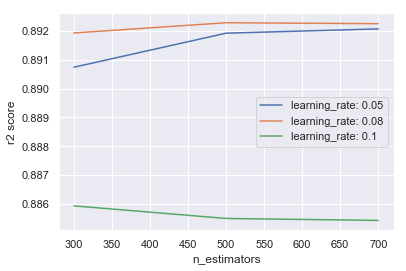

In [17]:
# plot results 
scores = np.array(means).reshape(len(learning_rate), len(n_estimators)) 
for i, value in enumerate(learning_rate): 
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value)) 
    plt.legend() 
    plt.xlabel('n_estimators' )
    plt.ylabel('r2 score')

In [18]:
# Initialize final model
XGB_final = XGBRegressor(learning_rate=0.08, n_estimators=500)

# Fit and predict (with early stopping)
XGB_final.fit(X_train, y_train, 
              early_stopping_rounds=20, 
              eval_metric='rmse',
              eval_set=[(X_test, y_test)], 
              verbose=False)

y_train_pred = XGB_final.predict(X_train)
y_pred = XGB_final.predict(X_test)

# Output results
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))

train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9867767406828775
Test r2 score:  0.8857473809948746
Train RMSE: 8845.6136
Test RMSE: 28310.1711


## Save final data and model

In [25]:
 X.to_csv('data/interim/features_XGB', index=False)
pd.DataFrame(y).to_csv('data/interim/labels_XGB', index=False)
joblib.dump(XGB_final, 'models/XGB_final.pkl')
%store feature_names_XGB

Stored 'feature_names_XGB' (Index)


---